In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from adtk.data import validate_series
from adtk.visualization import plot

In [227]:
df = pd.read_csv("./DailyDelhiClimateTrain.csv") # index_col="date"
df.set_index(pd.DatetimeIndex(df['date']), inplace=True)

In [160]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
date,,,,,
2013-01-01,2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,2013-01-05,6.000000,86.833333,3.700000,1016.500000


### Data overview

Weather in Delhi from 2013-01-01 to 2017-01-01). 
* mean temperature, humidity of air, wind speed, and mean pressure.
* 1462 observations

In [228]:
df.shape

(1462, 5)

In [229]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
date,,,,,
2013-01-01,2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [230]:
df.date.min(), df.date.max()

('2013-01-01', '2017-01-01')

In [231]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


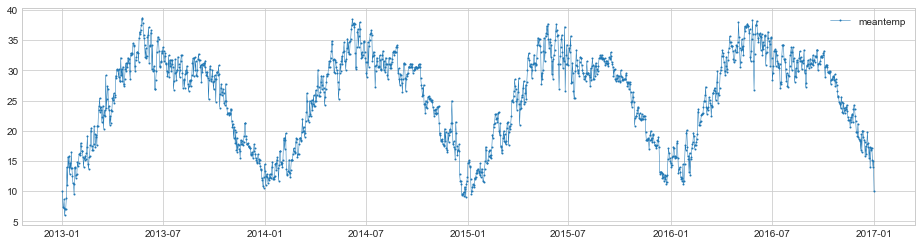

In [165]:
plot(validate_series(df['meantemp']))

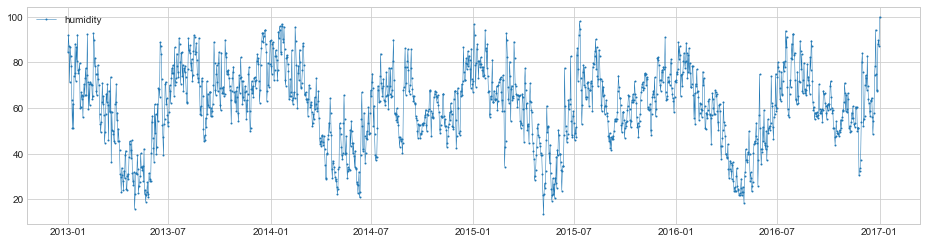

In [166]:
plot(validate_series(df['humidity']))

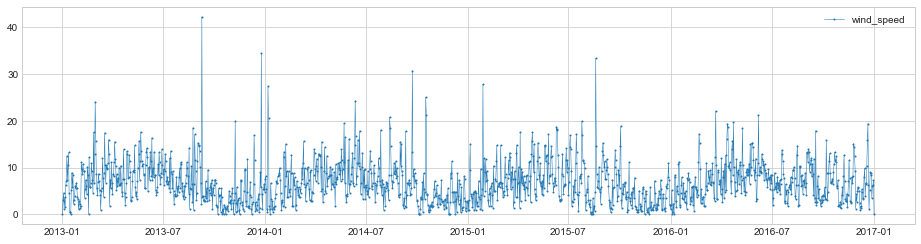

In [167]:
plot(validate_series(df['wind_speed']))

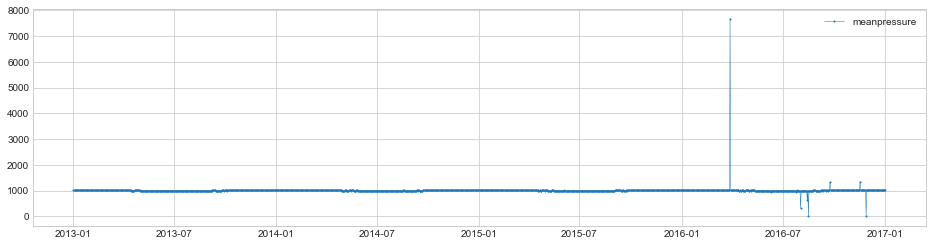

In [168]:
plot(validate_series(df['meanpressure']))

## Hurst Exponent, R/S analysis

The number of lags is not defined strictly, and is usually around 25-30, according to the known implementations.

In [232]:
def get_hurst_exponent(time_series, max_lag=25):
    
    """
        Hurst Exponent of the time series.
    """
    
    lags = range(2, max_lag)

    # the standard deviation of the differences between a series and its lagged version, for each lag.
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]

    # slope of the log-log plot of the number of lags against stds.
    hurst = np.polyfit(np.log(lags), np.log(tau), 1)

    return hurst[0]

#### Real data

In [233]:
for lag in [20, 100, 250, 500, 750]:
    hurst_exp = get_hurst_exponent(df["meantemp"].values, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

Hurst exponent with 20 lags: 0.2429
Hurst exponent with 100 lags: 0.5020
Hurst exponent with 250 lags: 0.4682
Hurst exponent with 500 lags: 0.1145
Hurst exponent with 750 lags: 0.0684


Observations. Almost at every single point H < 0.5, which means that time series is anti-persistent (or mean-reverting): an increase will most likely be followed by a decrease or vice-versa (so the mean will hold).
* with a default value of 20 lags, the series is quite mean-reverting. 
* as the number of lags is increased to 100, we see the sudden rise of H to 0.5, the "white noise" or a random geometric walk.
* and then the series keeps on reverting to the mean (H = 0.06, very close to 0, at 750 lags).

In [156]:
for lag in [20, 100, 250, 500, 750]:
    hurst_exp = get_hurst_exponent(df["humidity"].values, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

Hurst exponent with 20 lags: 0.1472
Hurst exponent with 100 lags: 0.2693
Hurst exponent with 250 lags: 0.1544
Hurst exponent with 500 lags: 0.0568
Hurst exponent with 750 lags: 0.0228


* close to mean reverting

In [157]:
for lag in [20, 100, 250, 500, 750]:
    hurst_exp = get_hurst_exponent(df["wind_speed"].values, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

Hurst exponent with 20 lags: 0.0214
Hurst exponent with 100 lags: 0.0307
Hurst exponent with 250 lags: 0.0579
Hurst exponent with 500 lags: 0.0108
Hurst exponent with 750 lags: 0.0064


* clearly mean reverting

In [154]:
for lag in [20, 100, 250, 500, 750]:
    hurst_exp = get_hurst_exponent(df["meanpressure"].values, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

Hurst exponent with 20 lags: 0.0033
Hurst exponent with 100 lags: 0.0088
Hurst exponent with 250 lags: 0.0219
Hurst exponent with 500 lags: -0.0673
Hurst exponent with 750 lags: -0.0431


* clearly mean reverting

#### synthetically generated data

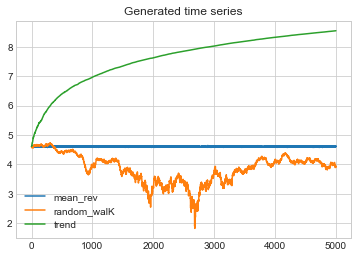

In [158]:
sample_size = 5000
scalar = 100

np.random.seed(42)

data = \
{
    # the mean is reverting completely - Hurst exp should be 0.
    "mean_rev": np.log(np.random.randn(sample_size) + scalar), 
    
    # random walk - H should be around 0.5
    "random_walK": np.log(np.cumsum(np.random.randn(sample_size)) + scalar), 
    
    # trend - H should be > 0.5
    "trend": np.log(np.cumsum(np.random.randn(sample_size) + 1) + scalar), 
}

df = pd.DataFrame(data)

df.plot(title="Generated time series");

In [80]:
for lag in [20, 100, 250, 500]:
    print(f"Hurst exponents with {lag} lags ----")
    for column in df.columns:
        print(f"{column}: {get_hurst_exponent(df[column].values, lag):.4f}")

Hurst exponents with 20 lags ----
mean_rev: -0.0007
random_walK: 0.4602
trend: 0.8878
Hurst exponents with 100 lags ----
mean_rev: 0.0007
random_walK: 0.4683
trend: 0.8685
Hurst exponents with 250 lags ----
mean_rev: 0.0001
random_walK: 0.4564
trend: 0.8410
Hurst exponents with 500 lags ----
mean_rev: 0.0003
random_walK: 0.3994
trend: 0.7940


Clearly, all the previously made assumptions are confirmed. 

## Anomaly detection

### Machine Learning - detecting anomalies with adtk toolkit

In [237]:
from adtk.detector import SeasonalAD, AutoregressionAD, VolatilityShiftAD

SeasonalAD uses a seasonal decomposition transformer to remove seasonal
pattern (as well as trend optional), and identifies a time point as
anomalous when the residual of seasonal decomposition is anomalously large.

### weather dataset - checking for anomalies

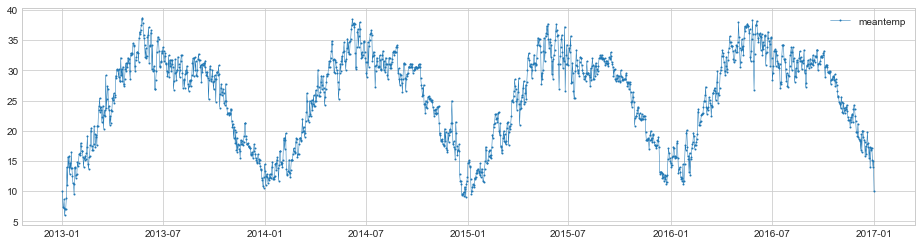

In [174]:
df = pd.read_csv("./DailyDelhiClimateTrain.csv") # index_col="date"
df.set_index(pd.DatetimeIndex(df['date']), inplace=True)

plot(validate_series(df['meantemp']))

In [175]:
seasonal_ad = SeasonalAD()

In [176]:
ts = validate_series(df['meantemp'])
anomalies = seasonal_ad.fit_detect(ts)

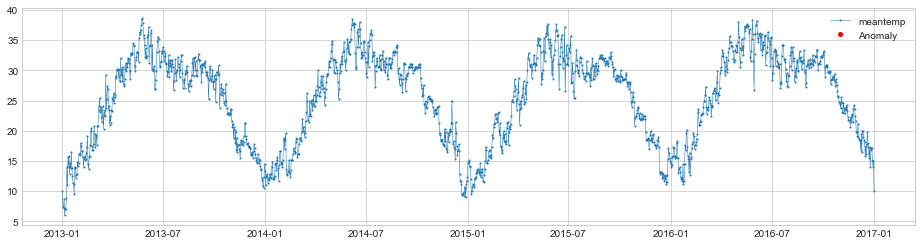

In [177]:
plot(ts, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

No anomalies detected.

### checking artificial data with anomalies

In [238]:
# df = pd.read_csv("./DailyDelhiClimateTrain.csv") # index_col="date"

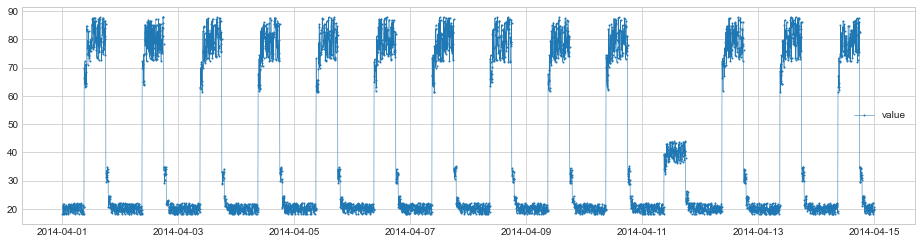

In [240]:
df = pd.read_csv("./kma21-22/artificialWithAnomaly/artificialWithAnomaly/art_daily_jumpsdown.csv")
df.set_index(pd.DatetimeIndex(df['timestamp']), inplace=True)

plot(validate_series(df['value']))

In [241]:
model = SeasonalAD() # SeasonalAD() AutoregressionAD()

* Detector that detects anomalous values away from seasonal pattern.
* This detector uses a seasonal decomposition transformer to remove seasonal
pattern (as well as trend optional), and identifies a time point as
anomalous when the residual of seasonal decomposition is anomalously large.

In [242]:
ts = validate_series(df['value'])
anomalies = model.fit_detect(ts)

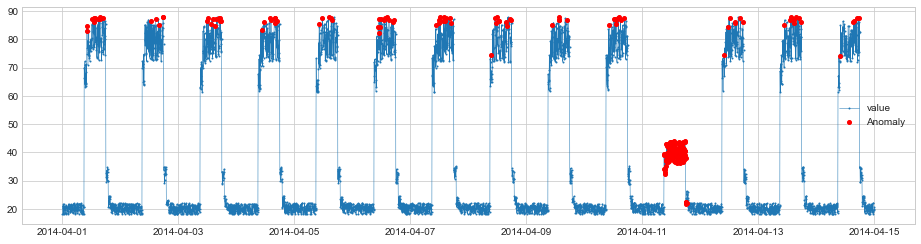

In [243]:
# SeasonalAD
plot(ts, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

In [245]:
model = VolatilityShiftAD(c=3.0, side='positive', window=30)

In [246]:
ts = validate_series(df['value'])
anomalies = model.fit_detect(ts)

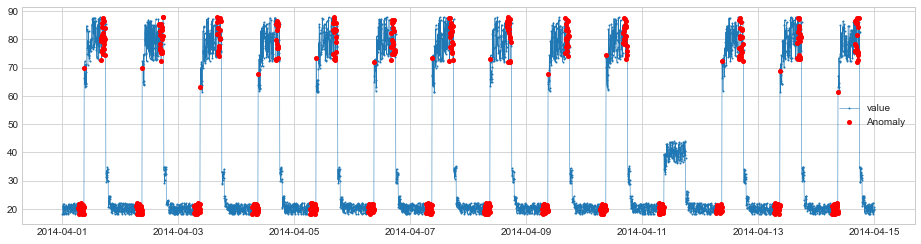

In [247]:
# VolatilityShiftAD
plot(ts, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

In [248]:
model = AutoregressionAD()

In [249]:
ts = validate_series(df['value'])
anomalies = model.fit_detect(ts)

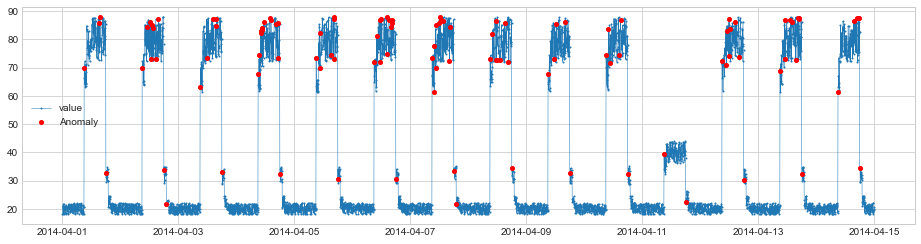

In [251]:
# Autoregression
plot(ts, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

The anomalies have been found: present at each of the peaks. The big cluster of anomaly-classified datapoints is within the unusually low value in 2014-04-12

### more artificial data

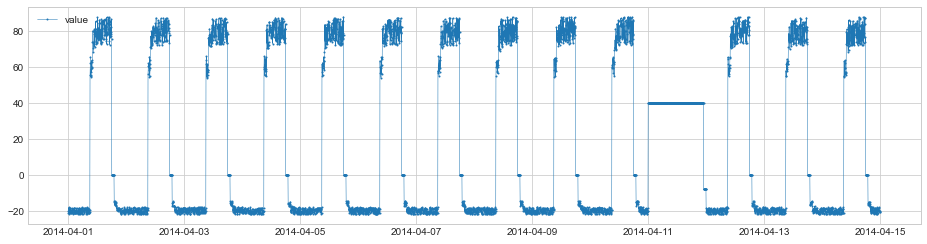

In [252]:
df = pd.read_csv("./kma21-22/artificialWithAnomaly/artificialWithAnomaly/art_daily_flatmiddle.csv")
df.set_index(pd.DatetimeIndex(df['timestamp']), inplace=True)

plot(validate_series(df['value']))

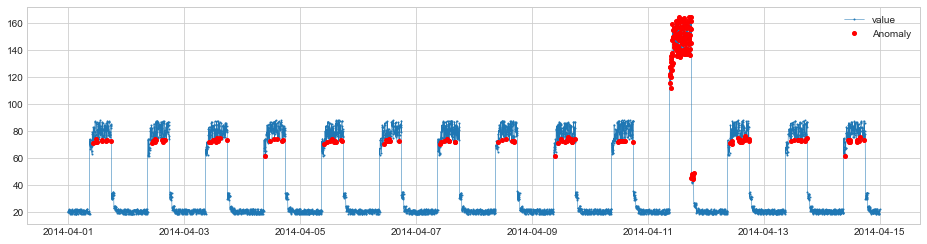

In [256]:
ts = validate_series(df['value'])
anomalies = seasonal_ad.fit_detect(ts)

plot(ts, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

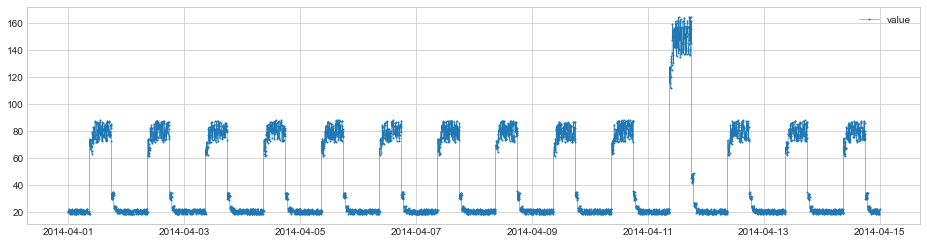

In [257]:
df = pd.read_csv("./kma21-22/artificialWithAnomaly/artificialWithAnomaly/art_daily_jumpsup.csv")
df.set_index(pd.DatetimeIndex(df['timestamp']), inplace=True)

plot(validate_series(df['value']))

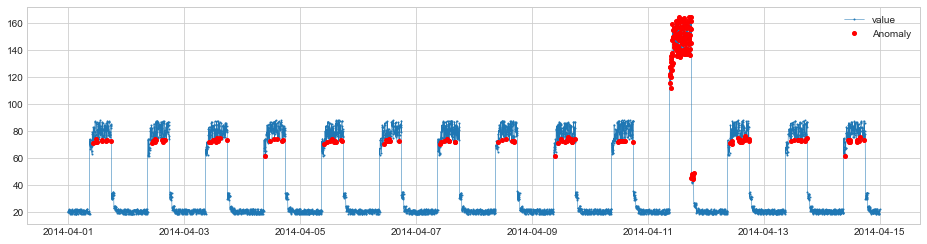

In [258]:
ts = validate_series(df['value'])
anomalies = seasonal_ad.fit_detect(ts)

plot(ts, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

Sources:
* https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data - daily weather in Delhi from 2013 to 2017
* https://www.kaggle.com/boltzmannbrain/nab - artificial time series data
* https://towardsdatascience.com/introduction-to-the-hurst-exponent-with-code-in-python-4da0414ca52e
* https://towardsdatascience.com/real-time-time-series-anomaly-detection-981cf1e1ca13
* https://github.com/arundo/adtk
* https://github.com/rob-med/awesome-TS-anomaly-detection